<a href="https://colab.research.google.com/github/hssitja/PhD-Dissertation/blob/Chapter-1/Chapter3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First steps

Set packages

In [ ]:
# Install
!pip install geopandas
!pip install -U plotly
!pip install --upgrade google-cloud-bigquery==2.30.1
!pip install basedosdados


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import
import pandas as pd
import numpy as np
import os
from zipfile import ZipFile
import geopandas as gpd
import matplotlib.pyplot as plt
from google.cloud import bigquery

# import basedosdados as bd

# Pandas graphics format
pd.options.plotting.backend = 'plotly'

Set data sources

In [ ]:
# Google Drive
from google.colab import drive, auth
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# File's paths
folder = '/content/drive/MyDrive/3 Essay political economy COVID19/Dados/Eleitorais/'
file_results_2020 = os.path.join(folder, 'votacao_candidato_munzona_2020.zip')
file_results_2016 = os.path.join(folder, 'votacao_candidato_munzona_2016.zip')
file_results_2018 = os.path.join(folder, 'votacao_candidato_munzona_2018.zip')
file_candidates_2020 = os.path.join(folder, 'consulta_cand_2020.zip')
file_candidates_2016 = os.path.join(folder, 'consulta_cand_2016.zip')
file_ideology = os.path.join(folder,'partidos2020.csv')
file_ibge = '/content/drive/MyDrive/3 Essay political economy COVID19/Dados/Medidas/Base_MUNIC_2020.csv'
arquivo_BR_municipios_shapefile = '/content/drive/MyDrive/3 Essay political economy COVID19/Dados/Mapa/BR_Municipios_2019.shp'

Dataset NPI 

In [ ]:
# Cities
df = pd.read_csv("https://raw.githubusercontent.com/hssitja/PhD-Dissertation/Chapter-3/Dataset_Port_and_Eng.csv")

df_codigbe = pd.read_csv(
    "https://raw.githubusercontent.com/hssitja/PhD-Dissertation/Chapter-3/c%C3%B3digos_tse_igbe.csv"
    ).rename(columns = {'codigo_ibge' : 'Unique_id'})

df = pd.merge(df, df_codigbe, on='Unique_id').rename(columns = {'Unique_id' : 'codigo_ibge'})

In [ ]:
# States
df_estados = pd.read_csv(
    "https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/ad2e4c65c6af2d10807cf1af4a84bc1a381164bc/data/OxCGRT_latest.csv"
    , low_memory=False)

df_estados = df_estados.loc[df_estados.CountryCode == 'BRA', :]

Elections dataset

In [ ]:
# global variables
LOCAL = 'BRASIL' # UF ou BRASIL
TIPO_CANDIDATO = 'Prefeito' #Vereador ou Prefeito

In [ ]:
# 2018 presidential elections runoff results

with ZipFile(file_results_2018) as z:
  with z.open(f'votacao_candidato_munzona_2018_{LOCAL}.csv') as f:
    results_2018 = pd.read_csv(f,sep=';',encoding='ISO-8859-1', decimal=','
    ).rename(columns = {'CD_MUNICIPIO' : 'codigo_tse'})

results_2018 = results_2018[results_2018['DS_CARGO'] == 'Presidente']

results_2018 = results_2018[results_2018['NR_TURNO'] == 2 ]

In [ ]:
# grouping results by city

results_2018 = results_2018.groupby(['codigo_tse','NM_URNA_CANDIDATO']).agg(
        { 'QT_VOTOS_NOMINAIS':'sum'})

results_2018 = results_2018.pivot_table('QT_VOTOS_NOMINAIS', "codigo_tse", "NM_URNA_CANDIDATO")

In [ ]:
# calculating the voting share

results_2018['Haddad_share'] = (
    results_2018['FERNANDO HADDAD'] / (results_2018['FERNANDO HADDAD'] + results_2018['JAIR BOLSONARO'])
    )

results_2018['Bolsonaro_share'] = (
    results_2018['JAIR BOLSONARO'] / (results_2018['FERNANDO HADDAD'] + results_2018['JAIR BOLSONARO'])
    )

df = pd.merge(df, results_2018, on='codigo_tse')

In [ ]:
type(df['codigo_tse'][0])

numpy.int64

In [ ]:
# 2020 local elections

with ZipFile(file_results_2020) as z:
  with z.open(f'votacao_candidato_munzona_2020_{LOCAL}.csv') as f:
    results_2020 = pd.read_csv(f,sep=';',encoding='ISO-8859-1', decimal=','
    ).rename(columns = {'CD_MUNICIPIO' : 'codigo_tse'})

In [ ]:
results_2020.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'codigo_tse',
       'NM_MUNICIPIO', 'NR_ZONA', 'CD_CARGO', 'DS_CARGO', 'SQ_CANDIDATO',
       'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'CD_SITUACAO_CANDIDATURA',
       'DS_SITUACAO_CANDIDATURA', 'CD_DETALHE_SITUACAO_CAND',
       'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO', 'NR_PARTIDO', 'SG_PARTIDO',
       'NM_PARTIDO', 'SQ_COLIGACAO', 'NM_COLIGACAO', 'DS_COMPOSICAO_COLIGACAO',
       'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO', 'ST_VOTO_EM_TRANSITO',
       'QT_VOTOS_NOMINAIS'],
      dtype='object')

In [ ]:
# Getting candidates info

with ZipFile(file_candidates_2020) as z:
  with z.open(f'consulta_cand_2020_{LOCAL}.csv') as f:
    candidates_2020 = pd.read_csv(f,sep=';',encoding='ISO-8859-1', decimal=',', low_memory=False)

In [ ]:
# Droping duplicates (drop first round when there was runoff)

candidates_2020 = candidates_2020.sort_values(by='NR_TURNO', ascending=False)\
.drop_duplicates(subset=['SQ_CANDIDATO'], keep='first')

In [ ]:
candidates_2020.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_CARGO', 'DS_CARGO',
       'SQ_CANDIDATO', 'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'NR_CPF_CANDIDATO', 'NM_EMAIL',
       'CD_SITUACAO_CANDIDATURA', 'DS_SITUACAO_CANDIDATURA',
       'CD_DETALHE_SITUACAO_CAND', 'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO',
       'NR_PARTIDO', 'SG_PARTIDO', 'NM_PARTIDO', 'SQ_COLIGACAO',
       'NM_COLIGACAO', 'DS_COMPOSICAO_COLIGACAO', 'CD_NACIONALIDADE',
       'DS_NACIONALIDADE', 'SG_UF_NASCIMENTO', 'CD_MUNICIPIO_NASCIMENTO',
       'NM_MUNICIPIO_NASCIMENTO', 'DT_NASCIMENTO', 'NR_IDADE_DATA_POSSE',
       'NR_TITULO_ELEITORAL_CANDIDATO', 'CD_GENERO', 'DS_GENERO',
       'CD_GRAU_INSTRUCAO', 'DS_GRAU_INSTRUCAO', 'CD_ESTADO_CIVIL',
       'DS_ESTADO_CIVIL', 'CD_COR_RACA', 'DS_COR_RACA', 'CD_OCUPACAO',
       '

In [ ]:
candidates_2020['DS_SIT_TOT_TURNO'].unique()

array(['NÃO ELEITO', 'ELEITO', 'SUPLENTE', 'ELEITO POR QP',
       'ELEITO POR MÉDIA', '#NULO#'], dtype=object)

In [ ]:
# Summing total votes by cities/round for each city

results_2020['QT_VOTOS_VALIDOS'] = results_2020.groupby(['codigo_tse', 'NR_TURNO','DS_CARGO'])['QT_VOTOS_NOMINAIS'].transform('sum')

In [ ]:
# Calculating total votes by each candidate and droping first round when there were run off

top_candidates_2020 = results_2020[results_2020['DS_CARGO']== TIPO_CANDIDATO]\
.sort_values(by='NR_TURNO',ascending=False)\
.groupby(['NR_CANDIDATO','codigo_tse','NR_TURNO'])\
.agg({'NM_URNA_CANDIDATO' :'first', 'NM_CANDIDATO':'first', 'NM_MUNICIPIO' :'first',  
      'DS_SIT_TOT_TURNO' :'first', 'NR_PARTIDO' :'first', 'SG_PARTIDO' :'first',
      'SQ_CANDIDATO': 'first', 'QT_VOTOS_NOMINAIS' : 'sum' , 'QT_VOTOS_VALIDOS':'first', 'DS_SIT_TOT_TURNO':'first'})\
      .sort_values(by='QT_VOTOS_NOMINAIS',ascending=False)\
      .drop_duplicates(subset=['SQ_CANDIDATO'], keep='first')

In [ ]:
# adding voting share

top_candidates_2020['PERCENTUAL'] = top_candidates_2020['QT_VOTOS_NOMINAIS'] / top_candidates_2020['QT_VOTOS_VALIDOS']

In [ ]:
# Slicing to consider only the two most voted

top_candidates_2020 = top_candidates_2020.groupby(['codigo_tse']).head(2)

In [ ]:
top_candidates_2020

,,,NM_URNA_CANDIDATO,NM_CANDIDATO,NM_MUNICIPIO,DS_SIT_TOT_TURNO,NR_PARTIDO,SG_PARTIDO,SQ_CANDIDATO,QT_VOTOS_NOMINAIS,QT_VOTOS_VALIDOS,PERCENTUAL
NR_CANDIDATO,codigo_tse,NR_TURNO,,,,,,,,,,
45,71072,2,BRUNO COVAS,BRUNO COVAS LOPES,SÃO PAULO,ELEITO,45,PSDB,250000896546,3169121,5337230,0.593776
50,71072,2,GUILHERME BOULOS,GUILHERME CASTRO BOULOS,SÃO PAULO,NÃO ELEITO,50,PSOL,250000746936,2168109,5337230,0.406224
25,60011,2,EDUARDO PAES,EDUARDO DA COSTA PAES,RIO DE JANEIRO,ELEITO,25,DEM,190000688286,1629319,2543019,0.640703
10,60011,2,CRIVELLA,MARCELO BEZERRA CRIVELLA,RIO DE JANEIRO,NÃO ELEITO,10,REPUBLICANOS,190000684240,913700,2543019,0.359297
55,41238,1,KALIL,ALEXANDRE KALIL,BELO HORIZONTE,ELEITO,55,PSD,130000756879,784307,1237764,0.633648
...,...,...,...,...,...,...,...,...,...,...,...,...
20,61468,1,TIÃO LIMA,SEBASTIÃO DE LIMA,UBARANA,NÃO ELEITO,20,PSC,250001231491,55,1561,0.035234
19,74055,1,MARLENE,MARLENE SOARES GWAK,AGUDOS DO SUL,NÃO ELEITO,19,PODE,160001188499,52,2903,0.017913
15,13773,1,VERINHA VERAS,VERA LUCIA ARAUJO VERAS,CHAVAL,NÃO ELEITO,15,MDB,60000914717,45,5216,0.008627


In [ ]:
top_candidates_2020 = top_candidates_2020.reset_index()

In [ ]:
# Getting and merging reelection info

top_candidates_2020 = pd.merge(top_candidates_2020, candidates_2020[['SQ_CANDIDATO', 'ST_REELEICAO']], on='SQ_CANDIDATO', how='left')

In [ ]:
top_candidates_2020

,NR_CANDIDATO,codigo_tse,NR_TURNO,NM_URNA_CANDIDATO,NM_CANDIDATO,NM_MUNICIPIO,DS_SIT_TOT_TURNO,NR_PARTIDO,SG_PARTIDO,SQ_CANDIDATO,QT_VOTOS_NOMINAIS,QT_VOTOS_VALIDOS,PERCENTUAL,ST_REELEICAO
0,45,71072,2,BRUNO COVAS,BRUNO COVAS LOPES,SÃO PAULO,ELEITO,45,PSDB,250000896546,3169121,5337230,0.593776,N
1,50,71072,2,GUILHERME BOULOS,GUILHERME CASTRO BOULOS,SÃO PAULO,NÃO ELEITO,50,PSOL,250000746936,2168109,5337230,0.406224,N
2,25,60011,2,EDUARDO PAES,EDUARDO DA COSTA PAES,RIO DE JANEIRO,ELEITO,25,DEM,190000688286,1629319,2543019,0.640703,N
3,10,60011,2,CRIVELLA,MARCELO BEZERRA CRIVELLA,RIO DE JANEIRO,NÃO ELEITO,10,REPUBLICANOS,190000684240,913700,2543019,0.359297,N
4,55,41238,1,KALIL,ALEXANDRE KALIL,BELO HORIZONTE,ELEITO,55,PSD,130000756879,784307,1237764,0.633648,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10954,20,61468,1,TIÃO LIMA,SEBASTIÃO DE LIMA,UBARANA,NÃO ELEITO,20,PSC,250001231491,55,1561,0.035234,N
10955,19,74055,1,MARLENE,MARLENE SOARES GWAK,AGUDOS DO SUL,NÃO ELEITO,19,PODE,160001188499,52,2903,0.017913,N
10956,15,13773,1,VERINHA VERAS,VERA LUCIA ARAUJO VERAS,CHAVAL,NÃO ELEITO,15,MDB,60000914717,45,5216,0.008627,N
10957,55,27154,1,FLAVIO BARBOSA,FLAVIO JOSE DE MATOS BARBOSA,BELÉM,NÃO ELEITO,55,PSD,20000856823,32,2192,0.014599,N


In [ ]:
# Ideology data

parties = pd.read_csv(file_ideology)
ideology = pd.CategoricalDtype(categories=['direita', 'centro', 'esquerda'], ordered=True)
parties['Espectro'] = parties['Espectro'].astype(ideology)

In [ ]:
# Merging voting and ideology data

top_candidates_2020 = top_candidates_2020.merge(parties[['NR_PARTIDO','Espectro']], left_on='NR_PARTIDO',right_on='NR_PARTIDO')

In [ ]:
# Getting the winner...

winner_2020 = top_candidates_2020[top_candidates_2020['DS_SIT_TOT_TURNO'] == 'ELEITO']
winner_2020 = winner_2020[['codigo_tse','NM_URNA_CANDIDATO', 'NM_CANDIDATO', 'SQ_CANDIDATO', 'ST_REELEICAO', 'SG_PARTIDO', 'Espectro','QT_VOTOS_NOMINAIS', 'PERCENTUAL']].rename(columns = {
    'NM_URNA_CANDIDATO' : 'ELEITO_NM_URNA_CANDIDATO', 'SQ_CANDIDATO' : 'ELEITO_SQ_CANDIDATO', 'ST_REELEICAO' : 'ELEITO_ST_REELEICAO',
    'NM_CANDIDATO' : 'ELEITO_NM_CANDIDATO', 'SG_PARTIDO' : 'ELEITO_SG_PARTIDO', 'Espectro' : 'ELEITO_Espectro', 'QT_VOTOS_NOMINAIS': 'ELEITO_QT_VOTOS_NOMINAIS', 'PERCENTUAL': 'ELEITO_PERCENTUAL'})

In [ ]:
# ... and the runner up

runnerup_2020 = top_candidates_2020[top_candidates_2020['DS_SIT_TOT_TURNO'] == 'NÃO ELEITO']
runnerup_2020 = runnerup_2020[['codigo_tse','NM_URNA_CANDIDATO', 'NM_CANDIDATO', 'SQ_CANDIDATO', 'ST_REELEICAO', 'SG_PARTIDO', 'Espectro' ,'QT_VOTOS_NOMINAIS', 'PERCENTUAL']].rename(columns = {
    'NM_URNA_CANDIDATO' : 'N_ELEITO_NM_URNA_CANDIDATO', 'SQ_CANDIDATO' : 'N_ELEITO_SQ_CANDIDATO','ST_REELEICAO' : 'N_ELEITO_ST_REELEICAO',
    'NM_CANDIDATO' : 'N_ELEITO_NM_CANDIDATO', 'SG_PARTIDO' : 'N_ELEITO_SG_PARTIDO', 'Espectro' : 'N_ELEITO_espectro','QT_VOTOS_NOMINAIS': 'N_ELEITO_QT_VOTOS_NOMINAIS', 'PERCENTUAL': 'N_ELEITO_PERCENTUAL'})

In [ ]:
# 2016 local elections

with ZipFile(file_results_2016) as z:
  with z.open(f'votacao_candidato_munzona_2016_{LOCAL}.csv') as f:
    results_2016 = pd.read_csv(f,sep=';',encoding='ISO-8859-1', decimal=','
    ).rename(columns = {'CD_MUNICIPIO' : 'codigo_tse'})

In [ ]:
results_2016.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'codigo_tse',
       'NM_MUNICIPIO', 'NR_ZONA', 'CD_CARGO', 'DS_CARGO', 'SQ_CANDIDATO',
       'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'CD_SITUACAO_CANDIDATURA',
       'DS_SITUACAO_CANDIDATURA', 'CD_DETALHE_SITUACAO_CAND',
       'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO', 'NR_PARTIDO', 'SG_PARTIDO',
       'NM_PARTIDO', 'SQ_COLIGACAO', 'NM_COLIGACAO', 'DS_COMPOSICAO_COLIGACAO',
       'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO', 'ST_VOTO_EM_TRANSITO',
       'QT_VOTOS_NOMINAIS'],
      dtype='object')

In [ ]:
# Getting candidates info

with ZipFile(file_candidates_2016) as z:
  with z.open(f'consulta_cand_2016_{LOCAL}.csv') as f:
    candidates_2016 = pd.read_csv(f,sep=';',encoding='ISO-8859-1', decimal=',', low_memory=False)

In [ ]:
candidates_2016.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_CARGO', 'DS_CARGO',
       'SQ_CANDIDATO', 'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'NR_CPF_CANDIDATO', 'NM_EMAIL',
       'CD_SITUACAO_CANDIDATURA', 'DS_SITUACAO_CANDIDATURA',
       'CD_DETALHE_SITUACAO_CAND', 'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO',
       'NR_PARTIDO', 'SG_PARTIDO', 'NM_PARTIDO', 'SQ_COLIGACAO',
       'NM_COLIGACAO', 'DS_COMPOSICAO_COLIGACAO', 'CD_NACIONALIDADE',
       'DS_NACIONALIDADE', 'SG_UF_NASCIMENTO', 'CD_MUNICIPIO_NASCIMENTO',
       'NM_MUNICIPIO_NASCIMENTO', 'DT_NASCIMENTO', 'NR_IDADE_DATA_POSSE',
       'NR_TITULO_ELEITORAL_CANDIDATO', 'CD_GENERO', 'DS_GENERO',
       'CD_GRAU_INSTRUCAO', 'DS_GRAU_INSTRUCAO', 'CD_ESTADO_CIVIL',
       'DS_ESTADO_CIVIL', 'CD_COR_RACA', 'DS_COR_RACA', 'CD_OCUPACAO',
       '

In [ ]:
# Droping duplicates (drop first round when there was runoff)

candidates_2016 = candidates_2016.sort_values(by='NR_TURNO', ascending=False)\
.drop_duplicates(subset=['SQ_CANDIDATO'], keep='first')

In [ ]:
# Summing total votes by cities/round for each city

results_2016['QT_VOTOS_VALIDOS'] = results_2016.groupby(['codigo_tse', 'NR_TURNO','DS_CARGO'])['QT_VOTOS_NOMINAIS'].transform('sum')

In [ ]:
# Calculating total votes by each candidate and droping first round when there were run off

top_candidates_2016 = results_2016[results_2016['DS_CARGO']== TIPO_CANDIDATO]\
.sort_values(by='NR_TURNO',ascending=False)\
.groupby(['NR_CANDIDATO','codigo_tse','NR_TURNO'])\
.agg({'NM_URNA_CANDIDATO' :'first', 'NM_CANDIDATO':'first', 'NM_MUNICIPIO' :'first',  
      'DS_SIT_TOT_TURNO' :'first', 'NR_PARTIDO' :'first', 'SG_PARTIDO' :'first',
      'SQ_CANDIDATO': 'first', 'QT_VOTOS_NOMINAIS' : 'sum' , 'QT_VOTOS_VALIDOS':'first', 'DS_SIT_TOT_TURNO':'first'})\
      .sort_values(by='QT_VOTOS_NOMINAIS',ascending=False)\
      .drop_duplicates(subset=['SQ_CANDIDATO'], keep='first')

In [ ]:
# adding voting share

top_candidates_2016['PERCENTUAL'] = top_candidates_2016['QT_VOTOS_NOMINAIS'] / top_candidates_2016['QT_VOTOS_VALIDOS']

In [ ]:
# Getting only the incumbent

# top_candidates_2016['DS_SIT_TOT_TURNO'] = top_candidates_2016['DS_SIT_TOT_TURNO'].dropna() 

# top_candidates_2016 = top_candidates_2016[top_candidates_2016['DS_SIT_TOT_TURNO'] == 'ELEITO']

In [ ]:
# Slicing to consider only the two most voted

top_candidates_2016 = top_candidates_2016.groupby(['codigo_tse']).head(2)

In [ ]:
top_candidates_2016

,,,NM_URNA_CANDIDATO,NM_CANDIDATO,NM_MUNICIPIO,DS_SIT_TOT_TURNO,NR_PARTIDO,SG_PARTIDO,SQ_CANDIDATO,QT_VOTOS_NOMINAIS,QT_VOTOS_VALIDOS,PERCENTUAL
NR_CANDIDATO,codigo_tse,NR_TURNO,,,,,,,,,,
45,71072,1,JOÃO DORIA,JOÃO AGRIPINO DA COSTA DORIA JUNIOR,SÃO PAULO,ELEITO,45,PSDB,250000004975,3085187,5789891,0.532858
10,60011,2,CRIVELLA,MARCELO BEZERRA CRIVELLA,RIO DE JANEIRO,ELEITO,10,PRB,190000017952,1700030,2863692,0.593650
50,60011,2,MARCELO FREIXO,MARCELO RIBEIRO FREIXO,RIO DE JANEIRO,NÃO ELEITO,50,PSOL,190000003384,1163662,2863692,0.406350
25,38490,1,ACM NETO,ANTONIO CARLOS PEIXOTO DE MAGALHÃES NETO,SALVADOR,ELEITO,25,DEM,50000013459,982246,1327529,0.739905
13,71072,1,FERNANDO HADDAD,FERNANDO HADDAD,SÃO PAULO,NÃO ELEITO,13,PT,250000011576,967190,5789891,0.167048
...,...,...,...,...,...,...,...,...,...,...,...,...
10,92100,1,NILTON DA PATROL,NILTON DIAS DE SOUZA,CEZARINA,NÃO ELEITO,10,PRB,90000018969,136,3751,0.036257
45,16993,1,REGINALDO DANTAS,REGINALDO DANTAS DA SILVA,JANDAÍRA,NÃO ELEITO,45,PSDB,200000006541,115,3349,0.034339
33,57975,1,PROFESSOR WALTER,WALTER AGUIAR VALADÃO,VENDA NOVA DO IMIGRANTE,NÃO ELEITO,33,PMN,80000001213,84,8961,0.009374


In [ ]:
top_candidates_2016 = top_candidates_2016.reset_index()

In [ ]:
# Getting and merging reelection info

top_candidates_2016 = pd.merge(top_candidates_2016, candidates_2016[['SQ_CANDIDATO', 'ST_REELEICAO']], on='SQ_CANDIDATO', how='left')

In [ ]:
top_candidates_2016['INCUMBENTE_CANDIDATO_REELEICAO'] = top_candidates_2016['NM_CANDIDATO'].isin(candidates_2020['NM_CANDIDATO'].tolist())
top_candidates_2016['INCUMBENTE_REELEITO'] = top_candidates_2016['NM_CANDIDATO'].isin(candidates_2020[candidates_2020['DS_SIT_TOT_TURNO'] == 'ELEITO']['NM_CANDIDATO'].tolist())

In [ ]:
# Merging voting and ideology data

top_candidates_2016 = top_candidates_2016.merge(parties[['NR_PARTIDO','Espectro']], left_on='NR_PARTIDO',right_on='NR_PARTIDO')

In [ ]:
# Getting the winner

winner_2016 = top_candidates_2016[top_candidates_2016['DS_SIT_TOT_TURNO'] == 'ELEITO']
winner_2016 = winner_2016[['codigo_tse','NM_URNA_CANDIDATO', 'NM_CANDIDATO', 'SQ_CANDIDATO', 
                                           'ST_REELEICAO', 'SG_PARTIDO', 'Espectro','QT_VOTOS_NOMINAIS', 'PERCENTUAL', 'DS_SIT_TOT_TURNO', 
                                           'INCUMBENTE_CANDIDATO_REELEICAO', 'INCUMBENTE_REELEITO']].rename(columns = {
                                               'NM_URNA_CANDIDATO' : 'INCUMBENTE_NM_URNA_CANDIDATO', 'SQ_CANDIDATO' : 'INCUMBENTE_SQ_CANDIDATO', 
                                               'ST_REELEICAO' : 'INCUMBENTE_ST_REELEICAO', 'NM_CANDIDATO' : 'INCUMBENTE_NM_CANDIDATO', 
                                               'SG_PARTIDO' : 'INCUMBENTE_SG_PARTIDO', 'Espectro' : 'INCUMBENTE_Espectro', 
                                               'QT_VOTOS_NOMINAIS': 'INCUMBENTE_QT_VOTOS_NOMINAIS', 'PERCENTUAL': 'INCUMBENTE_PERCENTUAL',
                                               'DS_SIT_TOT_TURNO' : 'INCUMBENTE_DS_SIT_TOT_TURNO' })
                                           
# Important observation:  INCUMBENTE_ST_REELEICAO refers to 2016 election, i.e. the candidate is running for a second term in 2016.
#                         INCUMBENTE_CANDIDATO_REELEICAO  and INCUMBENTE_REELEITO refers to 2020 election, i.e. if the mayor elected for a first term in 2016
#                         went for a second term in 2020.

In [ ]:
winner_2016['INCUMBENTE_DS_SIT_TOT_TURNO'].unique()

array(['ELEITO'], dtype=object)

In [ ]:
# And the runner up

runnerup_2016 = top_candidates_2016[top_candidates_2016['DS_SIT_TOT_TURNO'] == 'NÃO ELEITO']
runnerup_2016 = runnerup_2016[['codigo_tse','NM_URNA_CANDIDATO', 'NM_CANDIDATO', 'SQ_CANDIDATO', 
                                           'ST_REELEICAO', 'SG_PARTIDO', 'Espectro','QT_VOTOS_NOMINAIS', 'PERCENTUAL', 'DS_SIT_TOT_TURNO']].rename(columns = {
                                               'NM_URNA_CANDIDATO' : 'N_ELEITO_2016_NM_URNA_CANDIDATO', 'SQ_CANDIDATO' : 'N_ELEITO_2016_SQ_CANDIDATO', 
                                               'ST_REELEICAO' : 'N_ELEITO_2016_ST_REELEICAO', 'NM_CANDIDATO' : 'N_ELEITO_2016_NM_CANDIDATO', 
                                               'SG_PARTIDO' : 'N_ELEITO_2016_SG_PARTIDO', 'Espectro' : 'N_ELEITO_2016_Espectro', 
                                               'QT_VOTOS_NOMINAIS': 'N_ELEITO_2016_QT_VOTOS_NOMINAIS', 'PERCENTUAL': 'N_ELEITO_2016_PERCENTUAL',
                                               'DS_SIT_TOT_TURNO' : 'N_ELEITO_2016_DS_SIT_TOT_TURNO' })

In [ ]:
# calculating the vote difference in 2016

top_candidates_2016 = pd.merge(winner_2016, runnerup_2016, on='codigo_tse', how='left')

top_candidates_2016['MARGIN_VICTORY'] = top_candidates_2016['INCUMBENTE_PERCENTUAL'] - top_candidates_2016['N_ELEITO_2016_PERCENTUAL']

# making sure values are all positive

top_candidates_2016['MARGIN_VICTORY']=top_candidates_2016.apply(lambda x: -1*x['MARGIN_VICTORY'] if x['MARGIN_VICTORY'] < 0 else x['MARGIN_VICTORY'], axis=1)

# defining as negative the difference when the incumbent lost reelection bid in 2016

top_candidates_2016['MARGIN_VICTORY']=top_candidates_2016.apply(lambda x: -1*x['MARGIN_VICTORY'] if (x['N_ELEITO_2016_ST_REELEICAO']=='S') & (x['INCUMBENTE_ST_REELEICAO']=='N') else x['MARGIN_VICTORY'], axis=1)


In [ ]:
top_candidates_2016['MARGIN_VICTORY'].min()

-0.8916487385096812

In [ ]:
# Merging

top_candidates_2020 = pd.merge(winner_2020, runnerup_2020, on='codigo_tse', how='left')

df = pd.merge(df, top_candidates_2020, on='codigo_tse')

df = pd.merge(df, top_candidates_2016, on='codigo_tse')

In [ ]:
# Defining a list of columns to keep

keep_columns = ['codigo_ibge','codigo_tse','Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality)','Q1. Start date ',
                'Q2. Restrictive measures to avoid circulation/ agglomeration of people','Q2. Start date ','Q3. Measures of social isolation, allowing ONLY essential services',
                'Q3. Start date ', 'Q4. Compulsory use of face covers','Q4. Start date ','Q5. Were any measures implemented to reduce the offer of public transportation?',
                'Q5. What was the percentage of reduction?', 'Q5. Start date ','Q6. Were measures of restriction and social isolation eased?','Q6. Start date ', 
                'nome_municipio', 'capital','FERNANDO HADDAD', 'JAIR BOLSONARO', 'Haddad_share', 'Bolsonaro_share']

keep_columns = keep_columns + top_candidates_2020.columns[1:].tolist() + top_candidates_2016.columns[1:].tolist()


In [ ]:
df = df[keep_columns]

In [ ]:
# Setting variable codigo_ibge as string

df['codigo_ibge'] = df['codigo_ibge'].map(str)
df[['N_ELEITO_SQ_CANDIDATO','N_ELEITO_2016_SQ_CANDIDATO']] = df[['N_ELEITO_SQ_CANDIDATO','N_ELEITO_2016_SQ_CANDIDATO']].astype('Int64')


**Data wrangling for logistic regression**

In [ ]:
df.columns

Index(['codigo_ibge', 'codigo_tse',
       'Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality)',
       'Q1. Start date ',
       'Q2. Restrictive measures to avoid circulation/ agglomeration of people',
       'Q2. Start date ',
       'Q3. Measures of social isolation, allowing ONLY essential services',
       'Q3. Start date ', 'Q4. Compulsory use of face covers',
       'Q4. Start date ',
       'Q5. Were any measures implemented to reduce the offer of public transportation?',
       'Q5. What was the percentage of reduction?', 'Q5. Start date ',
       'Q6. Were measures of restriction and social isolation eased?',
       'Q6. Start date ', 'nome_municipio', 'capital', 'FERNANDO HADDAD',
       'JAIR BOLSONARO', 'Haddad_share', 'Bolsonaro_share',
       'ELEITO_NM_URNA_CANDIDATO', 'ELEITO_NM_CANDIDATO',
       'ELEITO_SQ_CANDIDATO', 'ELEITO_ST_REELEICAO', 'ELEITO_SG_PARTIDO',
       'ELEITO_Espectro', 'ELEITO_QT_VOTOS_NOMINAIS', 'ELEITO_PERCENTUAL

In [ ]:
# Setting date columns to_datetime

date_columns = ['Q1. Start date ','Q2. Start date ','Q3. Start date ','Q4. Start date ','Q5. Start date ','Q6. Start date ']

df[date_columns] = df[date_columns].apply(pd.to_datetime, dayfirst=True, errors='coerce')

In [ ]:
# substituting "Sim" and "Não" with 0's and 1's

df = df.replace({'Sim': 1, 'Não': 0, True:1, False:0})


In [ ]:
# checking for NaN in dependent variables

y_columns = ['Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality)',
       'Q2. Restrictive measures to avoid circulation/ agglomeration of people',
       'Q3. Measures of social isolation, allowing ONLY essential services', 'Q4. Compulsory use of face covers',
       'Q5. Were any measures implemented to reduce the offer of public transportation?',
       'Q6. Were measures of restriction and social isolation eased?']

df[y_columns].isna().sum()

Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality)    1574
Q2. Restrictive measures to avoid circulation/ agglomeration of people                  1584
Q3. Measures of social isolation, allowing ONLY essential services                      1588
Q4. Compulsory use of face covers                                                       1594
Q5. Were any measures implemented to reduce the offer of public transportation?         1637
Q6. Were measures of restriction and social isolation eased?                            1600
dtype: int64

In [ ]:
# Checking NaN's

df[y_columns].apply(pd.value_counts, dropna=False)

,Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality),Q2. Restrictive measures to avoid circulation/ agglomeration of people,"Q3. Measures of social isolation, allowing ONLY essential services",Q4. Compulsory use of face covers,Q5. Were any measures implemented to reduce the offer of public transportation?,Q6. Were measures of restriction and social isolation eased?
0.0,1830,83,882,160,2139,1439
1.0,2094,3831,3028,3744,1722,2459
NaN,1574,1584,1588,1594,1637,1600


In [ ]:
# CREATING NPI INDEX BY SUMMING QUESTIONS 2, 3 AND 4

index_columns = ['Q2. Restrictive measures to avoid circulation/ agglomeration of people',
       'Q3. Measures of social isolation, allowing ONLY essential services', 'Q4. Compulsory use of face covers']

df['NPI_index'] = df[index_columns].dropna().sum(axis=1)

In [ ]:
df['NPI_index'].value_counts(dropna=False)

3.0    2867
NaN    1599
2.0     945
1.0      84
0.0       3
Name: NPI_index, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5498 entries, 0 to 5497
Data columns (total 59 columns):
 #   Column                                                                                Non-Null Count  Dtype         
---  ------                                                                                --------------  -----         
 0   codigo_ibge                                                                           5498 non-null   object        
 1   codigo_tse                                                                            5498 non-null   int64         
 2   Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality)  3924 non-null   float64       
 3   Q1. Start date                                                                        1995 non-null   datetime64[ns]
 4   Q2. Restrictive measures to avoid circulation/ agglomeration of people                3914 non-null   float64       
 5   Q2. Start date                    

In [ ]:
# Define the columns to check for duplicates
duplicate_columns = ['ELEITO_SQ_CANDIDATO', 'N_ELEITO_SQ_CANDIDATO', 'INCUMBENTE_SQ_CANDIDATO', 'N_ELEITO_2016_SQ_CANDIDATO']

# Check for duplicates in the defined columns
duplicates = df[duplicate_columns].duplicated(keep=False)

# Print the duplicate rows
print(df[duplicates])

Empty DataFrame
Columns: [codigo_ibge, codigo_tse, Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality), Q1. Start date , Q2. Restrictive measures to avoid circulation/ agglomeration of people, Q2. Start date , Q3. Measures of social isolation, allowing ONLY essential services, Q3. Start date , Q4. Compulsory use of face covers, Q4. Start date , Q5. Were any measures implemented to reduce the offer of public transportation?, Q5. What was the percentage of reduction?, Q5. Start date , Q6. Were measures of restriction and social isolation eased?, Q6. Start date , nome_municipio, capital, FERNANDO HADDAD, JAIR BOLSONARO, Haddad_share, Bolsonaro_share, ELEITO_NM_URNA_CANDIDATO, ELEITO_NM_CANDIDATO, ELEITO_SQ_CANDIDATO, ELEITO_ST_REELEICAO, ELEITO_SG_PARTIDO, ELEITO_Espectro, ELEITO_QT_VOTOS_NOMINAIS, ELEITO_PERCENTUAL, N_ELEITO_NM_URNA_CANDIDATO, N_ELEITO_NM_CANDIDATO, N_ELEITO_SQ_CANDIDATO, N_ELEITO_ST_REELEICAO, N_ELEITO_SG_PARTIDO, N_ELEITO_espectro, N_EL

In [ ]:
# Define the columns that should be matched in 'df' and 'candidates_2020/2016'
match_columns = ['ELEITO_SQ_CANDIDATO','N_ELEITO_SQ_CANDIDATO','INCUMBENTE_SQ_CANDIDATO','N_ELEITO_2016_SQ_CANDIDATO']

# Define the columns that should be added to 'df' from 'candidates_2020/2016'
add_columns = ['NR_IDADE_DATA_POSSE', 'DS_GENERO','DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_OCUPACAO']

# Create a dictionary to store the column prefixes for each match column
prefixes = {
    'ELEITO_SQ_CANDIDATO': 'ELEITO_',
    'N_ELEITO_SQ_CANDIDATO': 'N_ELEITO_',
    'INCUMBENTE_SQ_CANDIDATO': 'INCUMBENTE_',
    'N_ELEITO_2016_SQ_CANDIDATO': 'N_ELEITO_2016_'
}

#fill the NaN values with -1
df[match_columns] = df[match_columns].fillna(-1)

# Iterate through the match columns in 'df'
for match_column in match_columns:
    # Get the prefix for the current match column
    prefix = prefixes[match_column]
    
    # Check if the match column is from 'candidates_2020' or 'candidates_2016'
    if 'N_ELEITO_2016_SQ_CANDIDATO' in match_column:
        #Select specific columns to add 
        cand_2016 = candidates_2016[['SQ_CANDIDATO', 'NR_IDADE_DATA_POSSE', 'DS_GENERO','DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_OCUPACAO']]
        # Rename the columns
        cand_2016.columns = [prefix+'SQ_CANDIDATO', prefix+'NR_IDADE_DATA_POSSE', prefix+'DS_GENERO', prefix+'DS_GRAU_INSTRUCAO', prefix+'DS_COR_RACA', prefix+'DS_OCUPACAO']
        #Join the selected columns with 'df'
        df = pd.merge(df,cand_2016, left_on=match_column, right_on=prefix+'SQ_CANDIDATO', how='left')
    
    elif 'INCUMBENTE_SQ_CANDIDATO' in match_column:
        #Select specific columns to add 
        cand_2016_2 = candidates_2016[['SQ_CANDIDATO', 'NR_IDADE_DATA_POSSE', 'DS_GENERO','DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_OCUPACAO']]
        # Rename the columns
        cand_2016_2.columns = [prefix+'SQ_CANDIDATO', prefix+'NR_IDADE_DATA_POSSE', prefix+'DS_GENERO', prefix+'DS_GRAU_INSTRUCAO', prefix+'DS_COR_RACA', prefix+'DS_OCUPACAO']
        #Join the selected columns with 'df'
        df = pd.merge(df,cand_2016_2, left_on=match_column, right_on=prefix+'SQ_CANDIDATO', how='left')

    elif 'N_ELEITO_SQ_CANDIDATO' in match_column:
        #Select specific columns to add 
        cand_2020_2 = candidates_2020[['SQ_CANDIDATO', 'NR_IDADE_DATA_POSSE', 'DS_GENERO','DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_OCUPACAO']]
        # Rename the columns
        cand_2020_2.columns = [prefix+'SQ_CANDIDATO', prefix+'NR_IDADE_DATA_POSSE', prefix+'DS_GENERO', prefix+'DS_GRAU_INSTRUCAO', prefix+'DS_COR_RACA', prefix+'DS_OCUPACAO']
        #Join the selected columns with 'df'
        df = pd.merge(df,cand_2020_2, left_on=match_column, right_on=prefix+'SQ_CANDIDATO', how='left')

    else:
        #Select specific columns to add 
        cand_2020 = candidates_2020[['SQ_CANDIDATO', 'NR_IDADE_DATA_POSSE', 'DS_GENERO','DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_OCUPACAO']]
        # Rename the columns
        cand_2020.columns = [prefix+'SQ_CANDIDATO', prefix+'NR_IDADE_DATA_POSSE', prefix+'DS_GENERO', prefix+'DS_GRAU_INSTRUCAO', prefix+'DS_COR_RACA', prefix+'DS_OCUPACAO']
        #Join the selected columns with 'df'
        df = pd.merge(df,cand_2020, left_on=match_column, right_on=prefix+'SQ_CANDIDATO', how='left')


In [ ]:
cand_2020.head()

,ELEITO_SQ_CANDIDATO,ELEITO_NR_IDADE_DATA_POSSE,ELEITO_DS_GENERO,ELEITO_DS_GRAU_INSTRUCAO,ELEITO_DS_COR_RACA,ELEITO_DS_OCUPACAO
90875,250000869099,39.0,MASCULINO,SUPERIOR INCOMPLETO,BRANCA,"TÉCNICO DE ELETRICIDADE, ELETRÔNICA E TELECOMU..."
481732,210001143104,50.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,ADVOGADO
243018,250000764875,70.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,PROFESSOR DE ENSINO SUPERIOR
437342,250000673435,51.0,MASCULINO,SUPERIOR COMPLETO,PRETA,VEREADOR
554905,250000733763,66.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,MÉDICO


In [ ]:
pd.options.display.max_rows = 90
df.head(10)

,codigo_ibge,codigo_tse,Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality),Q1. Start date,Q2. Restrictive measures to avoid circulation/ agglomeration of people,Q2. Start date,"Q3. Measures of social isolation, allowing ONLY essential services",Q3. Start date,Q4. Compulsory use of face covers,Q4. Start date,...,INCUMBENTE_NR_IDADE_DATA_POSSE,INCUMBENTE_DS_GENERO,INCUMBENTE_DS_GRAU_INSTRUCAO,INCUMBENTE_DS_COR_RACA,INCUMBENTE_DS_OCUPACAO,N_ELEITO_2016_NR_IDADE_DATA_POSSE,N_ELEITO_2016_DS_GENERO,N_ELEITO_2016_DS_GRAU_INSTRUCAO,N_ELEITO_2016_DS_COR_RACA,N_ELEITO_2016_DS_OCUPACAO
0,5200050,93360,0.0,NaT,1.0,2020-03-15,0.0,NaT,1.0,2020-03-15,...,52.0,MASCULINO,ENSINO MÉDIO COMPLETO,PARDA,PREFEITO,50.0,MASCULINO,ENSINO MÉDIO COMPLETO,PARDA,EMPRESÁRIO
1,3100104,40010,1.0,2020-05-25,1.0,2020-03-23,1.0,2020-03-23,1.0,2020-05-11,...,60.0,MASCULINO,SUPERIOR INCOMPLETO,PARDA,SERVIDOR PÚBLICO MUNICIPAL,72.0,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,BRANCA,PREFEITO
2,5200100,92010,1.0,2020-04-20,1.0,2020-03-15,1.0,2020-03-15,1.0,2020-03-10,...,52.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,ADMINISTRADOR,69.0,FEMININO,SUPERIOR COMPLETO,BRANCA,PEDAGOGO
3,3100203,40037,0.0,NaT,1.0,2020-03-16,1.0,2020-03-16,1.0,2020-05-14,...,65.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,ADVOGADO,43.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,ADVOGADO
4,1500107,4014,1.0,2020-03-29,1.0,2020-04-15,0.0,NaT,1.0,2020-04-10,...,48.0,MASCULINO,SUPERIOR COMPLETO,PARDA,VEREADOR,51.0,MASCULINO,ENSINO MÉDIO COMPLETO,PARDA,VEREADOR
5,2300101,13013,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,76.0,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,BRANCA,APOSENTADO (EXCETO SERVIDOR PÚBLICO),44.0,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,PARDA,COMERCIANTE
6,2900108,33014,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,51.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,EMPRESÁRIO,53.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,SERVIDOR PÚBLICO MUNICIPAL
7,2900207,33030,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,48.0,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,PARDA,EMPRESÁRIO,38.0,MASCULINO,SUPERIOR INCOMPLETO,PARDA,"ESTUDANTE, BOLSISTA, ESTAGIÁRIO E ASSEMELHADOS"
8,4100103,74012,1.0,2020-04-20,1.0,2020-03-23,1.0,2020-03-27,1.0,2020-04-14,...,57.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,EMPRESÁRIO,59.0,FEMININO,ENSINO FUNDAMENTAL INCOMPLETO,BRANCA,PREFEITO
9,4200051,80225,0.0,NaT,1.0,2020-03-23,1.0,2020-03-23,0.0,NaT,...,44.0,MASCULINO,SUPERIOR COMPLETO,BRANCA,CONTADOR,55.0,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,BRANCA,AGRICULTOR


In [ ]:
df[['ELEITO_NM_CANDIDATO','ELEITO_DS_GENERO','N_ELEITO_NM_CANDIDATO','N_ELEITO_DS_GENERO','INCUMBENTE_NM_CANDIDATO','INCUMBENTE_DS_GENERO','N_ELEITO_2016_NM_CANDIDATO','N_ELEITO_2016_DS_GENERO']]

,ELEITO_NM_CANDIDATO,ELEITO_DS_GENERO,N_ELEITO_NM_CANDIDATO,N_ELEITO_DS_GENERO,INCUMBENTE_NM_CANDIDATO,INCUMBENTE_DS_GENERO,N_ELEITO_2016_NM_CANDIDATO,N_ELEITO_2016_DS_GENERO
0,WANDER SARAIVA DE CARVALHO,MASCULINO,JOSÉ ANTÔNIO DO PRADO,MASCULINO,ROMES GOMES E SILVA,MASCULINO,VALDECI SALVIANO MENDONÇA,MASCULINO
1,WANDERLEI LEMES SANTOS,MASCULINO,VAGNER TOMAZ DE SOUZA,MASCULINO,WANDERLEI LEMES SANTOS,MASCULINO,ISVALDINO DE ASSUNÇÃO,MASCULINO
2,JOSÉ APARECIDO ALVES DINIZ,MASCULINO,ALESSANDRO SILVERIO DE ALMEIDA,MASCULINO,JOSE APARECIDO ALVES DINIZ,MASCULINO,FRANCISCA LEDA DE OLIVEIRA ALMADA,FEMININO
3,IVANIR DELADIER DA COSTA,MASCULINO,WILSON MARCELO DA SILVA,MASCULINO,ARMANDO GRECO FILHO,MASCULINO,CLAUDIO DE SOUSA VALADARES,MASCULINO
4,FRANCINETI MARIA RODRIGUES CARVALHO,FEMININO,ALCIDES EUFRASIO DA CONCEIÇAO NEGRÃO,MASCULINO,ALCIDES EUFRASIO DA CONCEIÇÃO NEGRÃO,MASCULINO,ELTON EDINÉZIO MAUES DA SILVA,MASCULINO
...,...,...,...,...,...,...,...,...
5493,REINALDO TEIXEIRA BRAGA FILHO,MASCULINO,EDUARDO PESSOA DA SILVA,MASCULINO,REINALDO TEIXEIRA BRAGA FILHO,MASCULINO,EDUARDO PESSOA DA SILVA,MASCULINO
5494,SEBASTIÃO DALYSON DE LIMA NEVES,MASCULINO,MARCIO FELLIPE BEZERRA NEVES,MASCULINO,SEBASTIÃO DALYSON DE LIMA NEVES,MASCULINO,SEBASTIÃO DE SOUSA FEITOSA FILHO,MASCULINO
5495,HEDER JEAN BRUNO DE OLIVEIRA,MASCULINO,REGINALDO ALVES DA SILVA,MASCULINO,LUCINÉIA ZACARIAS,FEMININO,ARNALDO APARECIDO DIONISIO,MASCULINO
5496,MARIA JOSENILDA CUNHA RODRIGUES,FEMININO,JOSE FERREIRA COSTA,MASCULINO,MARIA JOSENILDA CUNHA RODRIGUES,FEMININO,JOSÉ FERREIRA COSTA,MASCULINO


In [ ]:
auth.authenticate_user()
project_id = "phd-dissertation-343113"
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
# Set up the BigQuery client
client = bigquery.Client(project=project_id)

# Define the query
query = """
WITH table2 AS (
  SELECT
    table1.*,
    (SELECT sigla_uf FROM `basedosdados.br_bd_diretorios_brasil.municipio`
     WHERE id_municipio = table1.id_municipio
    ) AS sigla_uf,
    table1.ano AS ano_pib
  FROM `basedosdados.br_ibge_pib.municipio` AS table1
  WHERE table1.ano = (SELECT MAX(ano) FROM `basedosdados.br_ibge_pib.municipio`)
)

SELECT
  table2.*,
  population.populacao
FROM table2
JOIN `basedosdados.br_ibge_populacao.municipio` population
ON table2.id_municipio = population.id_municipio
WHERE population.ano = 2020
"""

# Execute the query and store the results in a dataframe
query_result = client.query(query).to_dataframe()

# Merge the query result with "df" dataframe
df = pd.merge(df, query_result, left_on='codigo_ibge', right_on='id_municipio')


/usr/local/lib/python3.9/dist-packages/google/cloud/bigquery/table.py:1563: UserWarning:

Dependency google-cloud-bigquery-storage is outdated, please upgrade it to version >= 2.0.0 (version found: 0.0.0).



In [ ]:
df_ibge = pd.read_csv(file_ibge, sep=';')

#slicing to keep relevant cols
relevant_cols = ['CodMun','Mcov01','Mcov04','Mcov053','Mcov0511','Mcov061', 'Mcov062', 'Mcov063', 'Mcov064', 'Mcov065', 'Mcov066',
                 'Mcov067', 'Mcov068', 'Mcov069', 'Mcov0610', 'Mcov0611', 'Mcov0612','Mcov0613', 'Mcov0614', 'Mcov0615', 'Mcov0616',
                 'Mcov0617', 'Mcov0618', 'Mcov0619', 'Mcov0620', 'Mcov0621', 'Mcov10', 'Mcov16']
df_ibge = df_ibge[relevant_cols]
df_ibge = df_ibge.rename(columns={'Mcov10':'no_beds_2020', 'Mcov16':'deaths_2020'})
df_ibge.head(5)

,CodMun,Mcov01,Mcov04,Mcov053,Mcov0511,Mcov061,Mcov062,Mcov063,Mcov064,Mcov065,...,Mcov0614,Mcov0615,Mcov0616,Mcov0617,Mcov0618,Mcov0619,Mcov0620,Mcov0621,no_beds_2020,deaths_2020
0,1100015,"Sim, foi decretado isolamento social",Não,Sim,Não,Não,Não,Não,Sim,Não,...,Não,Sim,Não,Não,Não,Não,Sim,Não,Sim,Sim
1,1100023,"Sim, foi decretado isolamento social",Não,Sim,Não,Não,Não,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Sim,Não,Não,Sim
2,1100031,"Sim, a população foi orientada para permanecer...","Sim, para estabelecimentos",Sim,Não,Não,Não,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Sim
3,1100049,"Sim, foi decretado isolamento social","Sim, para cidadãos e estabelecimentos",Sim,Não,Sim,Não,Não,Sim,Não,...,Não,Sim,Não,Não,Não,Sim,Sim,Não,Sim,Sim
4,1100056,"Sim, foi decretado isolamento social","Sim, para cidadãos e estabelecimentos",Sim,Não,Sim,Sim,Sim,Sim,Sim,...,Sim,Sim,Sim,Sim,Sim,Sim,Sim,Não,Não,Sim


In [ ]:
df_ibge['Mcov01'] = df_ibge['Mcov01'].replace('Sim, foi decretado isolamento social', 2)
df_ibge['Mcov01'] = df_ibge['Mcov01'].replace('Sim, a população foi orientada para permanecer em isolamento social', 1)
df_ibge['Mcov04'] = df_ibge['Mcov04'].replace('Sim, para cidadãos e estabelecimentos', 2)
df_ibge['Mcov04'] = df_ibge['Mcov04'].replace('Sim, para estabelecimentos', 1)
df_ibge['Mcov04'] = df_ibge['Mcov04'].replace('Sim, para cidadãos', 1)
df_ibge = df_ibge.replace('Não', 0)
df_ibge = df_ibge.replace('Sim', 1)
df_ibge = df_ibge.replace('Não informou', np.nan)
df_ibge = df_ibge.replace('Recusa', np.nan)
df_ibge = df_ibge.replace('-', np.nan)

In [ ]:
df_ibge.columns

Index(['CodMun', 'Mcov01', 'Mcov04', 'Mcov053', 'Mcov0511', 'Mcov061',
       'Mcov062', 'Mcov063', 'Mcov064', 'Mcov065', 'Mcov066', 'Mcov067',
       'Mcov068', 'Mcov069', 'Mcov0610', 'Mcov0611', 'Mcov0612', 'Mcov0613',
       'Mcov0614', 'Mcov0615', 'Mcov0616', 'Mcov0617', 'Mcov0618', 'Mcov0619',
       'Mcov0620', 'Mcov0621', 'no_beds_2020', 'deaths_2020'],
      dtype='object')

In [ ]:
# create a new column that is the sum of Mcov01, Mcov04, and Mcov053
df_ibge['NPI_ibge'] = df_ibge[['Mcov01', 'Mcov04', 'Mcov053']].apply(lambda x: np.nan if x.isna().any() else x.sum(), axis=1)
df_ibge['NPI_ibge'].value_counts()

5.0    2023
4.0    1496
3.0    1411
2.0     449
1.0      74
0.0       9
Name: NPI_ibge, dtype: int64

In [ ]:
# create a new column that is the sum of social protection measures 
df_ibge['social_protection'] = df_ibge[['Mcov0511', 'Mcov061', 'Mcov062', 'Mcov063', 'Mcov064',
                               'Mcov065', 'Mcov066', 'Mcov067', 'Mcov068', 'Mcov069', 
                               'Mcov0610', 'Mcov0611', 'Mcov0612', 'Mcov0613', 'Mcov0614',
                               'Mcov0615', 'Mcov0616', 'Mcov0617', 'Mcov0618', 'Mcov0619',
                               'Mcov0620', 'Mcov0621']].apply(lambda x: np.nan if x.isna().any() else x.sum(), axis=1)
df_ibge['social_protection'].value_counts()

9.0     458
8.0     445
6.0     426
7.0     417
5.0     396
10.0    391
4.0     369
3.0     353
11.0    336
12.0    327
13.0    276
2.0     270
14.0    230
1.0     220
15.0    152
16.0    118
17.0    100
18.0     67
0.0      40
19.0     40
20.0     17
21.0     11
22.0      7
Name: social_protection, dtype: int64

In [ ]:
df_ibge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CodMun             5570 non-null   int64  
 1   Mcov01             5467 non-null   float64
 2   Mcov04             5462 non-null   float64
 3   Mcov053            5466 non-null   float64
 4   Mcov0511           5466 non-null   float64
 5   Mcov061            5467 non-null   float64
 6   Mcov062            5467 non-null   float64
 7   Mcov063            5467 non-null   float64
 8   Mcov064            5467 non-null   float64
 9   Mcov065            5467 non-null   float64
 10  Mcov066            5467 non-null   float64
 11  Mcov067            5467 non-null   float64
 12  Mcov068            5467 non-null   float64
 13  Mcov069            5467 non-null   float64
 14  Mcov0610           5467 non-null   float64
 15  Mcov0611           5467 non-null   float64
 16  Mcov0612           5467 

In [ ]:
# mergin dataframes
df_ibge['CodMun'] = df_ibge['CodMun'].astype(str)
df = pd.merge(df, df_ibge[['CodMun','NPI_ibge','social_protection','no_beds_2020','deaths_2020']], left_on='codigo_ibge', right_on='CodMun')
# df.drop('CodMun', axis=1)

In [ ]:
# saving dataframe as .csv file

df.to_csv(os.path.join(folder,'df.csv'), index=False)

Info on candidates

In [ ]:
soma_dois_primeiros = top_candidates_2020['ELEITO_PERCENTUAL'] + top_candidates_2020['N_ELEITO_PERCENTUAL']
teste = soma_dois_primeiros == 1
(teste.value_counts(),soma_dois_primeiros.mean())

(False    3348
 True     2195
 dtype: int64, 0.908741259089024)

In [ ]:
candidates = df[['ELEITO_SQ_CANDIDATO','N_ELEITO_SQ_CANDIDATO']]
len(candidates)

5498

In [ ]:
candidates = pd.DataFrame(candidates)
candidates.to_csv(os.path.join(folder,'candidates.csv'), index=False)

**MAPS**

In [ ]:
geo_df = gpd.read_file(arquivo_BR_municipios_shapefile).rename(columns={'CD_MUN':'codigo_ibge'})

In [ ]:
geo_df = geo_df.merge(df, left_on='codigo_ibge', right_on='codigo_ibge')

In [ ]:
geo_df.columns

Index(['codigo_ibge', 'NM_MUN', 'SIGLA_UF', 'AREA_KM2', 'geometry',
       'codigo_tse',
       'Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality)',
       'Q1. Start date ',
       'Q2. Restrictive measures to avoid circulation/ agglomeration of people',
       'Q2. Start date ',
       ...
       'CodMun_y', 'NPI_ibge_y', 'social_protection_y', 'no_beds_2020_y',
       'deaths_2020_y', 'CodMun', 'NPI_ibge', 'social_protection',
       'no_beds_2020', 'deaths_2020'],
      dtype='object', length=120)

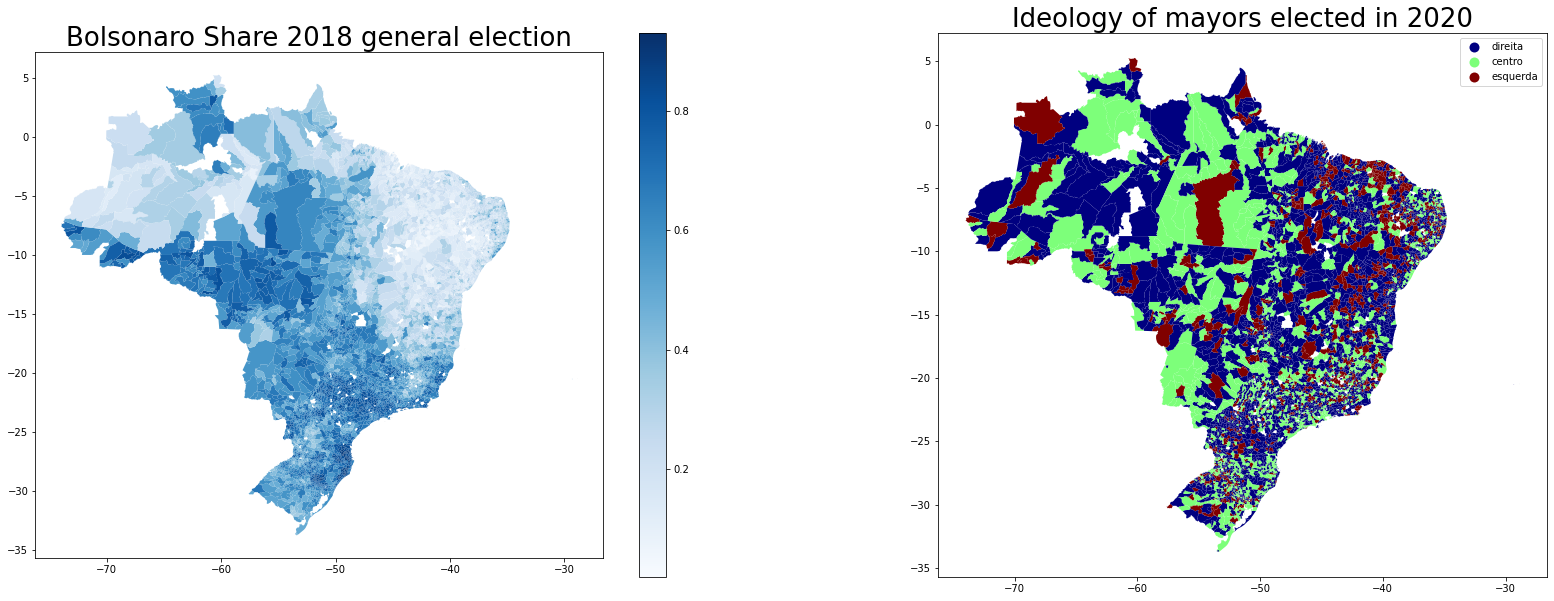

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(28,10))
ax[0].set_title(f'Bolsonaro Share 2018 general election', color='black', size=26)
ax[1].set_title(f'Ideology of mayors elected in 2020', color='black', size=26)

geo_df.plot(column='Bolsonaro_share', legend=True, cmap='Blues', ax=ax[0])
geo_df.plot(column='ELEITO_Espectro', legend=True, cmap='jet', ax=ax[1]);

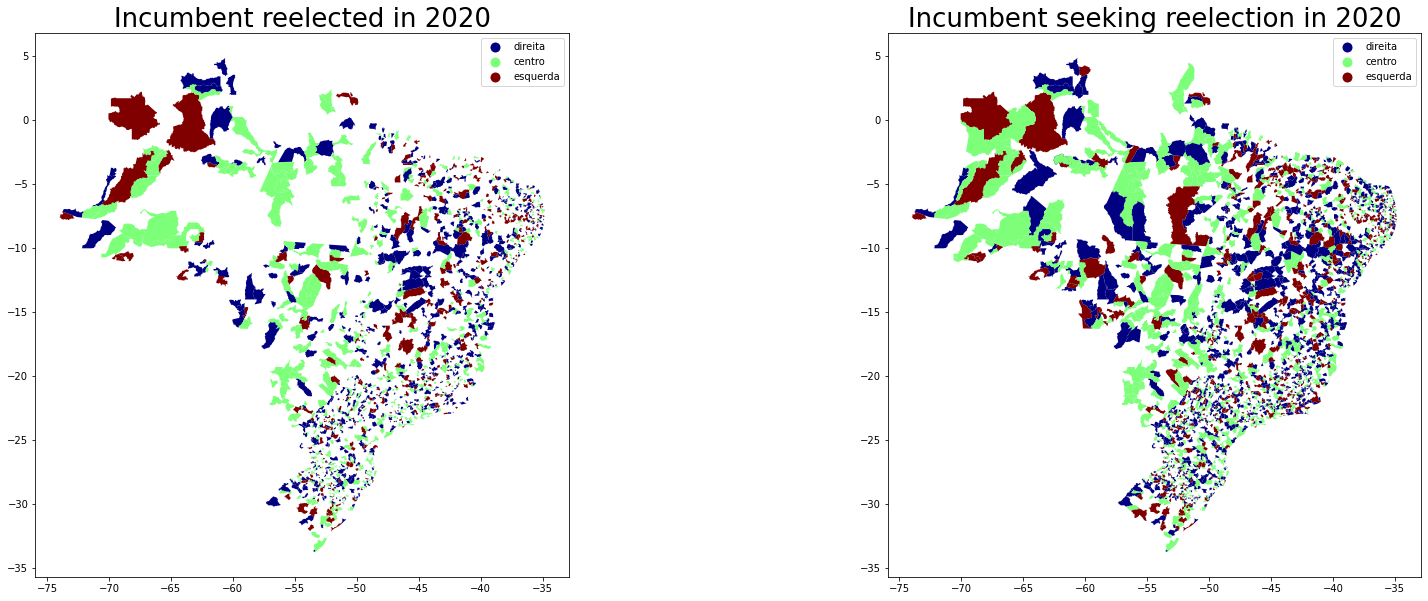

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(28,10))
ax[0].set_title(f'Incumbent reelected in 2020', color='black', size=26)
ax[1].set_title(f'Incumbent seeking reelection in 2020', color='black', size=26)

geo_df[geo_df['INCUMBENTE_REELEITO'] == True].plot(column='INCUMBENTE_Espectro', legend=True, cmap='jet', ax=ax[0])
geo_df[geo_df['INCUMBENTE_CANDIDATO_REELEICAO'] == True].plot(column='INCUMBENTE_Espectro', legend=True, cmap='jet', ax=ax[1]);

Descriptive statistics

In [ ]:
df[df['INCUMBENTE_CANDIDATO_REELEICAO'] == True][['Bolsonaro_share','INCUMBENTE_PERCENTUAL']].describe()

,Bolsonaro_share,INCUMBENTE_PERCENTUAL
count,2750.000000,2750.000000
mean,0.466541,0.547454
std,0.219970,0.124652
min,0.043400,0.176478
25%,0.258706,0.497012
50%,0.501507,0.536429
75%,0.655861,0.588994
max,0.877278,1.000000


In [ ]:
descriptive_columns = ['count','mean','std','min','max']
descriptive_rows = ['Bolsonaro_share','INCUMBENTE_PERCENTUAL']

In [ ]:
table1 = df[df['INCUMBENTE_CANDIDATO_REELEICAO'] == True][descriptive_rows].describe().transpose().loc[:,descriptive_columns]
table2 = df[df['INCUMBENTE_CANDIDATO_REELEICAO'] == False][descriptive_rows].describe().transpose().loc[:,descriptive_columns]

In [ ]:
descriptive = df.rename(columns={'INCUMBENTE_CANDIDATO_REELEICAO':'Trying reelection?', 'INCUMBENTE_Espectro':'Ideology'}).groupby(
    ['Trying reelection?','Ideology'])['Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality)']\
    .value_counts(normalize=True).round(4)*(100)

questions = ['Q2. Restrictive measures to avoid circulation/ agglomeration of people',
'Q3. Measures of social isolation, allowing ONLY essential services','Q4. Compulsory use of face covers','Q6. Were measures of restriction and social isolation eased?']

for question in questions:
  to_concat = descriptive2 = df.rename(columns={'INCUMBENTE_CANDIDATO_REELEICAO':'Trying reelection?', 'INCUMBENTE_Espectro':'Ideology'}).groupby(
    ['Trying reelection?','Ideology'])[question].value_counts(normalize=True).round(4)*(100)
  descriptive = pd.concat([descriptive,to_concat], axis=1)

In [ ]:
descriptive = descriptive.rename(columns={'Q1. Cordon Sanitaire (monitoring of entrance and exit of people in the municipality)':'Cordon Sanitaire',
                            'Q2. Restrictive measures to avoid circulation/ agglomeration of people':'Avoid agglomeration',
                            'Q3. Measures of social isolation, allowing ONLY essential services':'Commerce closure',
                            'Q4. Compulsory use of face covers':'Face covers','Q6. Were measures of restriction and social isolation eased?':'Measures eased'})

In [ ]:
descriptive

Cordon Sanitaire  Avoid agglomeration  \
Trying reelection? Ideology                                              
0                  direita  1.0             54.51                97.58   
                            0.0             45.49                 2.42   
                   centro   0.0             56.82                 1.99   
                            1.0             43.18                98.01   
                   esquerda 1.0             57.06                97.58   
                            0.0             42.94                 2.42   
1                  direita  1.0             58.38                98.00   
                            0.0             41.62                 2.00   
                   centro   1.0             52.05                97.87   
                            0.0             47.95                 2.13   
                   esquerda 1.0             56.51                98.36   
                            0.0             43.49                 1.64   

                                 Commerce closure  Face covers  Measures eased  
Trying reelection? Ideology                                                     
0                  direita  1.0             79.44        96.30           62.48  
                            0.0             20.56         3.70           37.52  
                   centro   0.0             23.04         4.15           37.48  
                            1.0             76.96        95.85           62.52  
                   esquerda 1.0             76.36        96.95           64.63  
                            0.0             23.64         3.05           35.37  
1                  direita  1.0             77.01        95.37           64.03  
                            0.0             22.99         4.63           35.97  
                   centro   1.0             76.17        95.45           64.30  
                            0.0             23.83         4.55           35.70  
                   esquerda 1.0             78.74        95.79           59.58  
                            0.0             21.26         4.21           40.42